In [1135]:
#Assignment 2

#21I-0259
#AI-K
#Jannat Butt

Import Libraries

In [1136]:
import zipfile
from google.colab import files
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
import torch.optim as optim
import cv2
import numpy as np
import os
from skimage.feature import greycomatrix, greycoprops
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from google.colab.patches import cv2_imshow
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import time
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pandas as pd

Setting up kaggle for direct access to the Data Set

In [988]:
!pip install kaggle

In [989]:
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [990]:
!kaggle datasets download -d brsdincer/vehicle-detection-image-set
zip_file_path = '/content/vehicle-detection-image-set.zip'
destination_dir = '/content/'


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print("Unzipped successfully!")


vehicle-detection-image-set.zip: Skipping, found more recently modified local copy (use --force to force download)
Unzipped successfully!


Calculating textture patterns using GLCM and some statistical features

In [ ]:
mean_intensity = []
std_deviation = []
contrast = []
energy = []
correlation = []
homogeneity = []
dissimilarity = []
rmse = []
entropy_val = []
aspect_ratio = []
elongation = []

class_labels = []

directories = ['/content/data/non-vehicles', '/content/data/vehicles']

# Loop through the image directories

for directory in directories:
    class_label = 'non-vehicles' if 'non-vehicles' in directory else 'vehicles'

    # Loop through the image files in the directory

    for filename in os.listdir(directory):
        if filename.endswith('.png'):  # images are in PNG format

            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Calculate the mean intensity

            mean = np.mean(image)
            mean_intensity.append(mean)

            # Calculate the standard deviation

            std = np.std(image)
            std_deviation.append(std)

            # Calculate contrast

            glcm = greycomatrix(image, [1], [0], symmetric=True, normed=True)

            contrast_val = greycoprops(glcm, 'contrast')[0, 0]
            contrast.append(contrast_val)

            #calculate energy

            energy_val = greycoprops(glcm, 'energy')[0, 0]
            energy.append(energy_val)

            # calculate correlation

            correlation_val = greycoprops(glcm, 'correlation')[0, 0]
            correlation.append(correlation_val)

            #calculate homogeneity

            homogeneity_val = greycoprops(glcm, 'homogeneity')[0, 0]
            homogeneity.append(homogeneity_val)

            # Calculate dissimilarity

            dissimilarity_val = greycoprops(glcm, 'dissimilarity')[0, 0]
            dissimilarity.append(dissimilarity_val)

            # Calculate RMSE

            rmse_val = np.sqrt(np.mean((image.astype(float) / 255) ** 2))
            rmse.append(rmse_val)

            # Calculate aspect ratio

            aspect_ratio_val = image.shape[1] / image.shape[0]
            aspect_ratio.append(aspect_ratio_val)

            # Calculate elongation

            elongation_val = aspect_ratio_val if aspect_ratio_val <= 1 else 1 / aspect_ratio_val
            elongation.append(elongation_val)

            class_labels.append(class_label)

# df
data = {
    'Mean Intensity': mean_intensity,
    'Standard Deviation': std_deviation,
    'Contrast': contrast,
    'Energy': energy,
    'Correlation': correlation,
    'Homogeneity': homogeneity,
    'Dissimilarity': dissimilarity,
    'RMSE': rmse,
    'Aspect Ratio': aspect_ratio,
    'Elongation': elongation,
    'Class': class_labels
}
df = pd.DataFrame(data)




Making classes as numeric

In [1015]:
df["Class"].replace({'non-vehicles': 0, 'vehicles': 1}, inplace=True)


In [1016]:
df

,Mean Intensity,Standard Deviation,Contrast,Energy,Correlation,Homogeneity,Dissimilarity,RMSE,Aspect Ratio,Elongation,Class
0,75.001221,50.502284,109.809276,0.027416,0.978459,0.244955,5.977927,0.354586,1.0,1.0,0
1,131.272949,50.575817,321.292659,0.060092,0.937371,0.279403,10.709325,0.551681,1.0,1.0,0
2,86.712158,34.166704,40.426091,0.047555,0.982629,0.400124,3.293155,0.365493,1.0,1.0,0
3,30.568604,8.383635,2.989087,0.084383,0.978704,0.510274,1.288690,0.124304,1.0,1.0,0
4,42.379883,5.175789,1.785962,0.168525,0.966560,0.650914,0.860863,0.167430,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
17755,36.220459,37.264416,97.016121,0.106442,0.963917,0.482275,4.651042,0.203792,1.0,1.0,1
17756,63.483398,33.649564,80.810764,0.044292,0.964033,0.360292,4.282986,0.281765,1.0,1.0,1
17757,98.742920,84.189664,738.684524,0.036479,0.948094,0.248490,12.984127,0.508869,1.0,1.0,1
17758,82.324951,79.476944,372.896825,0.052043,0.970137,0.346873,9.382937,0.448741,1.0,1.0,1


Total classes and there distribution

In [1017]:
class_counts = df['Class'].value_counts()
print("No of classes]\n",class_counts)


No of classes]
 0    8968
1    8792
Name: Class, dtype: int64


Converting named Columns to numeric for applying correlation

In [1018]:
old_columns=df.columns

# Create a list of numeric column names
new_column_names = [int(i) for i in range(len(df.columns))]

# Set the DataFrame's column names to the new numeric names
df.columns = new_column_names



In [1019]:
df

,0,1,2,3,4,5,6,7,8,9,10
0,75.001221,50.502284,109.809276,0.027416,0.978459,0.244955,5.977927,0.354586,1.0,1.0,0
1,131.272949,50.575817,321.292659,0.060092,0.937371,0.279403,10.709325,0.551681,1.0,1.0,0
2,86.712158,34.166704,40.426091,0.047555,0.982629,0.400124,3.293155,0.365493,1.0,1.0,0
3,30.568604,8.383635,2.989087,0.084383,0.978704,0.510274,1.288690,0.124304,1.0,1.0,0
4,42.379883,5.175789,1.785962,0.168525,0.966560,0.650914,0.860863,0.167430,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
17755,36.220459,37.264416,97.016121,0.106442,0.963917,0.482275,4.651042,0.203792,1.0,1.0,1
17756,63.483398,33.649564,80.810764,0.044292,0.964033,0.360292,4.282986,0.281765,1.0,1.0,1
17757,98.742920,84.189664,738.684524,0.036479,0.948094,0.248490,12.984127,0.508869,1.0,1.0,1
17758,82.324951,79.476944,372.896825,0.052043,0.970137,0.346873,9.382937,0.448741,1.0,1.0,1


In [1020]:
old_columns

Index(['Mean Intensity', 'Standard Deviation', 'Contrast', 'Energy',
       'Correlation', 'Homogeneity', 'Dissimilarity', 'RMSE', 'Aspect Ratio',
       'Elongation', 'Class'],
      dtype='object')

Finding the relation between features and Target

In [1021]:
correlation_matrix = df.iloc[:, :-1].corrwith(df[10])

#desired number of features

N =6
top_features1 = correlation_matrix.abs().sort_values(ascending=False).head(N)

In [1022]:
correlation_matrix

0   -0.175189
1    0.512027
2    0.407801
3   -0.231785
4   -0.161981
5   -0.303135
6    0.472436
7   -0.030552
8         NaN
9         NaN
dtype: float64

Extracting only top six Features from all

In [1023]:
result=df.iloc[:,top_features1.index.tolist()]

Mapping the numeric column names to Original Colun Names

In [1024]:
column_mapping = {col: old_columns[col] for col in result.columns}

# Rename the columns using the mapping dictionary

result.rename(columns=column_mapping, inplace=True)

<ipython-input-1024-704edd62d15f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result.rename(columns=column_mapping, inplace=True)


In [1025]:
selected_df=result

Final texture and statistical Features

In [1026]:
selected_df

,Standard Deviation,Dissimilarity,Contrast,Homogeneity,Energy,Mean Intensity
0,50.502284,5.977927,109.809276,0.244955,0.027416,75.001221
1,50.575817,10.709325,321.292659,0.279403,0.060092,131.272949
2,34.166704,3.293155,40.426091,0.400124,0.047555,86.712158
3,8.383635,1.288690,2.989087,0.510274,0.084383,30.568604
4,5.175789,0.860863,1.785962,0.650914,0.168525,42.379883
...,...,...,...,...,...,...
17755,37.264416,4.651042,97.016121,0.482275,0.106442,36.220459
17756,33.649564,4.282986,80.810764,0.360292,0.044292,63.483398
17757,84.189664,12.984127,738.684524,0.248490,0.036479,98.742920
17758,79.476944,9.382937,372.896825,0.346873,0.052043,82.324951


Applying Fast and Canny on images

In [1039]:
# Initialize empty lists to store image data and labels

data = []
labels = []

# Define the directories for 'vehicles' and 'non-vehicles'
directories = ['/content/data/non-vehicles', '/content/data/vehicles']

# Loop through the image directories
for directory in directories:
    if 'non-vehicles' in directory:
        label = 'non-vehicles'
    else:
        label = 'vehicles'

    # Loop through the image files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.png'):  # images are in PNG format
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load as a color image

            # Initialize the FAST detector
            fast = cv2.FastFeatureDetector_create()

            # Detect FAST keypoints
            keypoints = fast.detect(image, None)

            if keypoints:
                # Create an empty mask
                mask = np.zeros(image.shape[:2], dtype=np.uint8)

                # Set the pixels corresponding to keypoints to 255 in the mask
                for keypoint in keypoints:
                    x, y = map(int, keypoint.pt)
                    mask[y, x] = 255

                # Apply the mask to the original image to extract the pixels corresponding to keypoints
                keypoint_pixels = cv2.bitwise_and(image, image, mask=mask)

                # Convert the keypoint_pixels to grayscale (2D)
                keypoint_pixels = cv2.cvtColor(keypoint_pixels, cv2.COLOR_BGR2GRAY)

                # Append the label, filename, and keypoint_pixels to the data and labels lists
                data.append({
                    'Label': label,
                    'Filename': filename,
                    'Pixels': keypoint_pixels
                })
                labels.append(label)
            else:
                # If no keypoints were detected, try Canny edge detection with multiple thresholds
                edges_found = False
                for high_threshold in range(50, 30, -10):  # Start with high threshold and move downwards
                    edges = cv2.Canny(image, high_threshold, high_threshold * 2)

                    # Check if the edge map contains any non-zero values
                    if np.any(edges):
                        # Append the label, filename, and edge_pixels to the data and labels lists
                        data.append({
                            'Label': label,
                            'Filename': filename,
                            'Pixels': edges  # Store in the same 'Pixels' column
                        })
                        labels.append(label)
                        edges_found = True
                        break

                if not edges_found:
                    # If no edges were found, add the image with all pixels set to zero (completely black)
                    all_black = np.zeros(image.shape[:2], dtype=np.uint8)
                    data.append({
                        'Label': label,
                        'Filename': filename,
                        'Pixels': all_black  # Store in the same 'Pixels' column
                    })
                    labels.append(label)

#df
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('image_data.csv', index=False)


Image edge Detected by Canny

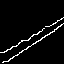

In [1040]:
specific_image_pixels = df[df["Filename"] == 'image772.png']['Pixels'].values[0]
cv2_imshow(specific_image_pixels)
cv2.waitKey(0)
cv2.destroyAllWindows()


Image kaypoints (key features as edges ) extracted by FAST algorithm

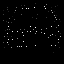

In [1041]:
specific_image_pixels = df[df["Filename"] == '99.png']['Pixels'].values[0]
cv2_imshow(specific_image_pixels)
cv2.waitKey(0)
cv2.destroyAllWindows()


Converting 2d features into seperate columns

In [1042]:
def split_2d_matrix(matrix):
    return pd.Series(matrix.flatten())


split = df['Pixels'].apply(split_2d_matrix)


new_df = pd.concat([df, split], axis=1)

new_df.drop(columns=['Pixels'], inplace=True)
df=new_df

In [1043]:
df

,Label,Filename,0,1,2,3,4,5,6,7,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,non-vehicles,extra4673.png,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,non-vehicles,extra7.png,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,non-vehicles,extra716.png,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,non-vehicles,image2167.png,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,non-vehicles,image2635.png,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17755,vehicles,3347.png,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17756,vehicles,far (391).png,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17757,vehicles,3556.png,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17758,vehicles,426.png,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Converting classes labels to 0 1

In [1044]:
df["Label"].replace({'non-vehicles': 0, 'vehicles': 1}, inplace=True)

Combining Statistical , Texture and Other Fast+Canny Features Togather

In [1045]:
df=pd.concat([df,selected_df],axis=1)

In [1046]:
df

,Label,Filename,0,1,2,3,4,5,6,7,...,4092,4093,4094,4095,Standard Deviation,Dissimilarity,Contrast,Homogeneity,Energy,Mean Intensity
0,0,extra4673.png,0,0,0,0,0,0,0,0,...,0,0,0,0,50.502284,5.977927,109.809276,0.244955,0.027416,75.001221
1,0,extra7.png,0,0,0,0,0,0,0,0,...,0,0,0,0,50.575817,10.709325,321.292659,0.279403,0.060092,131.272949
2,0,extra716.png,0,0,0,0,0,0,0,0,...,0,0,0,0,34.166704,3.293155,40.426091,0.400124,0.047555,86.712158
3,0,image2167.png,0,0,0,0,0,0,0,0,...,0,0,0,0,8.383635,1.288690,2.989087,0.510274,0.084383,30.568604
4,0,image2635.png,0,0,0,0,0,0,0,0,...,0,0,0,0,5.175789,0.860863,1.785962,0.650914,0.168525,42.379883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17755,1,3347.png,0,0,0,0,0,0,0,0,...,0,0,0,0,37.264416,4.651042,97.016121,0.482275,0.106442,36.220459
17756,1,far (391).png,0,0,0,0,0,0,0,0,...,0,0,0,0,33.649564,4.282986,80.810764,0.360292,0.044292,63.483398
17757,1,3556.png,0,0,0,0,0,0,0,0,...,0,0,0,0,84.189664,12.984127,738.684524,0.248490,0.036479,98.742920
17758,1,426.png,0,0,0,0,0,0,0,0,...,0,0,0,0,79.476944,9.382937,372.896825,0.346873,0.052043,82.324951


Train Test Splitting

In [1047]:
X = df.iloc[:, 2:]
y=df["Label"]

#making 30 percent as test and remaining 70 percent as training data

X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=45,
                                   test_size=0.3,
                                   shuffle=True)


Converting numpy arrays to tensors

In [1048]:
y_train=y_train.astype("float32")
y_test=y_test.astype("float32")

X_train=torch.tensor(X_train.values,dtype=torch.float32)
y_train=torch.tensor(np.array(y_train),dtype=torch.float32)
X_test=torch.tensor(np.array(X_test),dtype=torch.float32)
y_test=torch.tensor(np.array(y_test),dtype=torch.float32)


Making train and test Dataloaders

In [1049]:
#batch size
batch_size = 64

# Create a train DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a test DataLoader
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


Neural Network Architecture

In [1050]:
class vehicle_Classification(nn.Module):
    def __init__(self, input_dim):
        super(vehicle_Classification, self).__init__()

         # Input layer with 128 neurons
        self.input_layer = nn.Linear(input_dim, 128)

         # First hidden layer with 64 neurons
        self.hidden1 = nn.Linear(128, 64)

        # Second hidden layer with 32 neurons
        self.hidden2 = nn.Linear(64, 32)

        # Third hidden layer with 16 neurons
        self.hidden3 = nn.Linear(32, 16)

        # Fourth hidden layer with 8 neurons
        self.hidden4 = nn.Linear(16, 8)

        # Fifth hidden layer with 4 neurons
        self.hidden5 = nn.Linear(8, 4)

        # Output layer with 1 neuron and sigmoid activation
        self.output_layer = nn.Linear(4, 1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.hidden5(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        #print("l8",x)
        return x


Training Loop and Testing

Epoch [1/11] - Train Loss: 0.5863
Epoch [2/11] - Train Loss: 0.5182
Epoch [3/11] - Train Loss: 0.4742
Epoch [4/11] - Train Loss: 0.4371
Epoch [5/11] - Train Loss: 0.4045
Epoch [6/11] - Train Loss: 0.3738
Epoch [7/11] - Train Loss: 0.3460
Epoch [8/11] - Train Loss: 0.3193
Epoch [9/11] - Train Loss: 0.2961
Epoch [10/11] - Train Loss: 0.2760
Epoch [11/11] - Train Loss: 0.2585


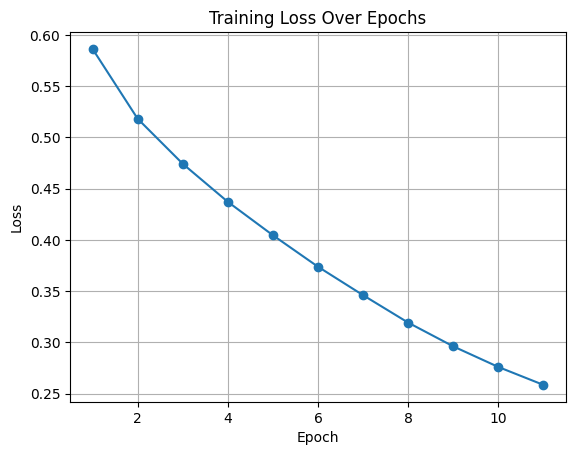

Training Time: 18.54 seconds
Test Accuracy: 0.8230


In [1130]:
#total features
input=  X_train.shape[1]

# making class instance

model = vehicle_Classification(input)

#USING SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)
#Binary Cross Entropy loss
criterion = nn.BCELoss()
start_time = time.time()

epochs = 11


train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for batch in train_dataloader:
        inputs, labels = batch

        # removing the previously calculated gradients

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.view(-1, 1))

        # computing the gradients of the loss with respect to the model's parameters for optimization
        loss.backward()
        #updating gradients
        optimizer.step()

        # summing each batch loss
        epoch_loss += loss.item()

    #claculating one epoch loss by using the above summed batches loss divided by the total number of batches
    average_loss = epoch_loss / len(train_dataloader)
    train_losses.append(average_loss)

    print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {average_loss:.4f}")

end_time = time.time()
training_time = end_time - start_time

# Plot the training loss curve
plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


# Evaluate the model on the test data
model.eval()
y_pred_classes = []
y_true = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        outputs = model(inputs)
        for output in outputs:
            # if prob is aove the thresh than it is classified as pos otherwie negative
            # we are not considering the class having thresh = 0.5 because it is not calssified to any class
            if output > 0.5:
                y_pred_classes.append(1)
            else:
                y_pred_classes.append(0)
        y_true.extend(labels)

accuracy_s = accuracy_score(y_true, y_pred_classes)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Test Accuracy: {accuracy_s:.4f}")


In [1131]:
report = classification_report(y_true, y_pred_classes)
print(report)

              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83      2673
         1.0       0.83      0.81      0.82      2655

    accuracy                           0.82      5328
   macro avg       0.82      0.82      0.82      5328
weighted avg       0.82      0.82      0.82      5328



ROC AUC Metrics

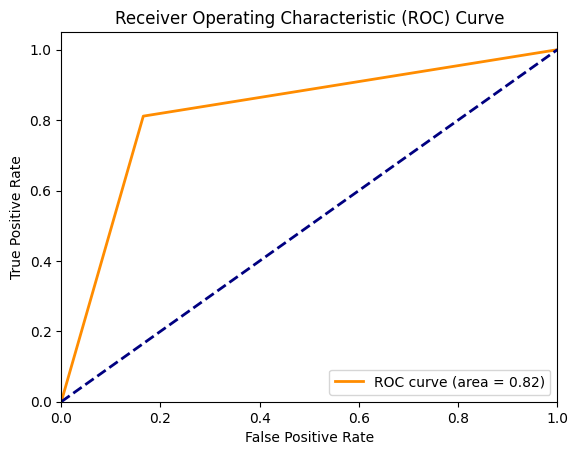

AUC: 0.82


In [1132]:
# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_classes)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC

print(f"AUC: {roc_auc:.2f}")


In [1133]:
mcc = matthews_corrcoef(y_true, y_pred_classes)

In [1134]:
mcc

0.6461490066225256

Architecture

In [1143]:
print(model)

vehicle_Classification(
  (input_layer): Linear(in_features=4102, out_features=128, bias=True)
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=16, bias=True)
  (hidden4): Linear(in_features=16, out_features=8, bias=True)
  (hidden5): Linear(in_features=8, out_features=4, bias=True)
  (output_layer): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
